In [1]:
import tensorflow as tf
import librosa
import numpy as np
import IPython.display as ipd
import os
import pyaudio
import wave
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt

## Loading samples

In [2]:
data = np.load('data/merged.npz')
X = data['sample']
Y = data['label']
X.shape

(3785, 20, 65, 1)

## Split into validation and train data

In [3]:
X_val = np.append(X[:120], X[-120:], axis=0)
X_train = X[120:-120]
Y_val = np.append(Y[:120], Y[-120:], axis=0)
Y_train = Y[120:-120]
X_val.shape

(240, 20, 65, 1)

## Preparing dataset

In [4]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).repeat().shuffle(len(X_val)).batch(32)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(len(X_train)).batch(256)

## Preparing model

In [12]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(20, 65, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [13]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [14]:
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train model

In [18]:
model.fit(train_dataset, epochs=4, validation_data=val_dataset, steps_per_epoch=2, validation_steps=4)

Train for 2 steps, validate for 4 steps
Epoch 1/4
2/2 [==============================] - 1s 371ms/step - loss: 0.6210 - accuracy: 0.9609 - val_loss: 0.6196 - val_accuracy: 0.9297
Epoch 2/4
2/2 [==============================] - 1s 348ms/step - loss: 0.6195 - accuracy: 0.9531 - val_loss: 0.6112 - val_accuracy: 0.9688
Epoch 3/4
2/2 [==============================] - 1s 354ms/step - loss: 0.6167 - accuracy: 0.9629 - val_loss: 0.6134 - val_accuracy: 0.9453
Epoch 4/4
2/2 [==============================] - 1s 350ms/step - loss: 0.6105 - accuracy: 0.9805 - val_loss: 0.6134 - val_accuracy: 0.9531


## Obtaining answer

#### Recording sample

In [27]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 1.5
for i in np.arange(700):
    WAVE_OUTPUT_FILENAME = "Mirz_lections/X_other_" + str(i) + ".wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording " + str(i))

    frames = []

    for j in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording " + str(i))

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

* recording 0
* done recording 0
* recording 1
* done recording 1
* recording 2
* done recording 2
* recording 3
* done recording 3
* recording 4
* done recording 4
* recording 5
* done recording 5
* recording 6
* done recording 6
* recording 7
* done recording 7
* recording 8
* done recording 8
* recording 9
* done recording 9
* recording 10
* done recording 10
* recording 11
* done recording 11
* recording 12
* done recording 12
* recording 13
* done recording 13
* recording 14
* done recording 14
* recording 15
* done recording 15
* recording 16
* done recording 16
* recording 17
* done recording 17
* recording 18
* done recording 18
* recording 19
* done recording 19
* recording 20
* done recording 20
* recording 21
* done recording 21
* recording 22
* done recording 22
* recording 23
* done recording 23
* recording 24
* done recording 24
* recording 25
* done recording 25
* recording 26
* done recording 26
* recording 27
* done recording 27
* recording 28
* done recording 28
* rec

#### Sample processing

In [20]:
x, sr = librosa.load(r"output.wav")
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=len(x)//64, n_mfcc=20)
# mfcc = mfcc.flatten()np.shape(X_other_copy)
print(mfcc.shape)

ipd.Audio(r"output.wav", rate=sr)
# "WAVE_OUTPUT_FILENAME"
#r"audiobooks/data/ru_open_stt/private_buriy_audiobooks_2/0/1d/07921cf11da9.wav"

(20, 65)


#### Model testing

In [21]:
# model.predict(X.values[2200].reshape(1, X.shape[1])
model.predict(mfcc.reshape(1, 20, 65, 1))

array([[0.38703316, 0.61296684]], dtype=float32)

#### Saving model

In [27]:
model.save('models\\64_hop_20_nmfcc_CNN_v_5.h5')

In [214]:
mfcc = X_val[3].reshape(20, 65)

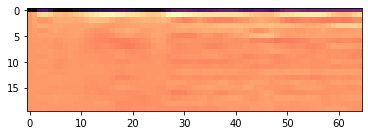

In [22]:
plt.imshow(mfcc, cmap='magma')

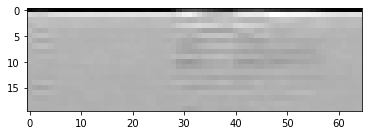

In [37]:
plt.imshow(mfcc, cmap='gray')

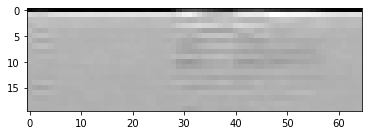

In [38]:
plt.imshow(mfcc, cmap='gray')

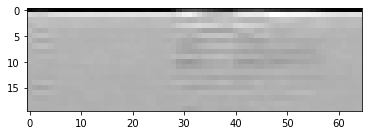

In [39]:
plt.imshow(mfcc, cmap='gray')